In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('./dataset.csv')

In [3]:
df.rename(columns={'Date of Award (2017-2022)': 'Date of Award'}, inplace=True)

In [4]:
df['Awarded Amount'] = df['Awarded Amount'].str.replace("$", "")
df['Awarded Amount'] = df['Awarded Amount'].str.replace(",", "")
df['Awarded Amount'] = df['Awarded Amount'].astype('float')

C:\Users\lqlau\AppData\Local\Temp\ipykernel_9088\44625767.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Awarded Amount'] = df['Awarded Amount'].str.replace("$", "")


In [5]:
df['Date of Award'] = pd.to_datetime(df['Date of Award'],format="%d/%m/%Y")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   S/N                      7000 non-null   int64         
 1   Procurement Code         7000 non-null   object        
 2   Procurement Type         7000 non-null   object        
 3   Agency                   7000 non-null   object        
 4   Procurement Description  7000 non-null   object        
 5   Date of Award            7000 non-null   datetime64[ns]
 6   Supplier                 7000 non-null   object        
 7   Awarded Amount           7000 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 437.6+ KB


In [7]:
def get_sum_and_count(df, subcols, group_cols): 
    '''
    Aggregates the sum and count awarded tender amount with user conditions
    '''
    output_df = df[subcols].groupby(group_cols)['Awarded Amount'].agg(['sum', 'count']).reset_index()
    output_df.rename(columns={'sum': 'awarded sum',
                                    'count': 'total number of awards'}, inplace=True)
    return output_df

def get_percentage_agency(df, compare_df): 
    '''
    Finds the percentage of a tender contract awarded compared to the sum of tender awards given by an agency
    '''
    sum_percentage_li = []
    count_percentage_li = []

    for row, col in df.iterrows(): 
        agency = col['Agency']
        sum_awarded_by_reason = col['awarded sum']
        count_awarded_by_reason = col['total number of awards']

        temp = compare_df[compare_df['Agency'] == agency]

        total_sum_awarded = temp['awarded sum']
        total_count_awarded = temp['total number of awards']

        sum_percentage = round(sum_awarded_by_reason / total_sum_awarded, 6).values[0]
        count_percentage = round(count_awarded_by_reason / total_count_awarded, 6).values[0]

        sum_percentage_li.append(sum_percentage)
        count_percentage_li.append(count_percentage)

    df['percentage awarded by amount_agency'] = sum_percentage_li
    df['percentage awarded by count_agency'] = count_percentage_li
    
    return df

def get_percentage_supplier(df, compare_df): 
    '''
    Finds the percentage of a tender contract awarded compared to the sum of tender awards given to a supplier
    '''
    sum_percentage_li = []
    count_percentage_li = []

    for row, col in df.iterrows(): 
        supplier = col['Supplier']
        sum_awarded_by_reason = col['awarded sum']
        count_awarded_by_reason = col['total number of awards']

        temp = compare_df[compare_df['Supplier'] == supplier]

        total_sum_awarded = temp['awarded sum']
        total_count_awarded = temp['total number of awards']

        sum_percentage = round(sum_awarded_by_reason / total_sum_awarded, 6).values[0]
        count_percentage = round(count_awarded_by_reason / total_count_awarded, 6).values[0]

        sum_percentage_li.append(sum_percentage)
        count_percentage_li.append(count_percentage)

    df['percentage awarded by amount_supplier'] = sum_percentage_li
    df['percentage awarded by count_supplier'] = count_percentage_li
    
    return df

def get_percentage_agency_supplier(df, compare_df): 
    '''
    Finds the percentage of a tender contract awarded compared to the sum of tender awards given by an agency to a supplier
    '''
    sum_percentage_li = []
    count_percentage_li = []

    for row, col in df.iterrows(): 
        agency = col['Agency']
        supplier = col['Supplier']
        sum_awarded_by_reason = col['awarded sum']
        count_awarded_by_reason = col['total number of awards']

        temp = compare_df[(compare_df['Agency'] == agency) & (compare_df['Supplier'] == supplier)]

        total_sum_awarded = temp['awarded sum']
        total_count_awarded = temp['total number of awards']

        sum_percentage = round(sum_awarded_by_reason / total_sum_awarded, 6).values[0]
        count_percentage = round(count_awarded_by_reason / total_count_awarded, 6).values[0]

        sum_percentage_li.append(sum_percentage)
        count_percentage_li.append(count_percentage)

    df['percentage awarded by amount'] = sum_percentage_li
    df['percentage awarded by count'] = count_percentage_li
    
    return df

# Report

### Find if any quotations are done wrongly

In [8]:
itt_incorrect = []
itq_incorrect = []

for row, col in df.iterrows(): 
    p_type = col['Procurement Type']
    amount = col['Awarded Amount']
    code = col['Procurement Code'][:3]
    if (p_type == 'ITQ' and (amount < 10000 or amount > 100000 or code != p_type)): 
        itq_incorrect.append(row)
    elif (p_type == 'ITT' and (amount < 100000 or code != p_type)): 
        itt_incorrect.append(row)
        
print(itt_incorrect, itq_incorrect)

[] [116, 261, 395, 628, 643, 806, 1098, 1194, 1315, 1391]


Observations: We found that 10 were called for an Invitation to Quote (ITQ) despite qualifying for $10,000 in small value purchase. We also found that there were no items misclassified under ITQ or Invitation to Tender (ITT). 

### General Observations

In [10]:
year = df['Date of Award'].dt.year

In [11]:
df.groupby(['Agency', year])['Awarded Amount'].agg(['count', 'mean', 'median', 'min', 'max']).to_csv('avg yr.csv')

In [14]:
month = df['Date of Award'].dt.month
year = df['Date of Award'].dt.year
df.groupby([year, month])['Awarded Amount'].agg(['sum', 'count']).head()

sum  count
Date of Award Date of Award                   
2016          7                 40532.0      1
2017          1              29929066.0    113
              2              36858811.0    146
              3              35654144.0    135
              4              34115522.0    134

Observations: On average, an agency will award about 467 tenders to various suppliers and each supplier has been awarded 71 tender contracts throughout the 5 years. The average awarded tender amount is SGD253,229.59 and median awarded tender amount is SGD242,789.50. 

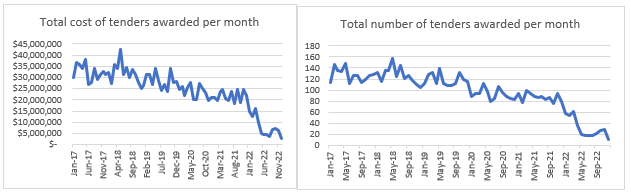

In May 2018, it has the most tender contracts awarded across the 5-year period. A general downward trend is observed in the number and cost of tenders awarded.

### Find which agency had the most awards and total sum of awards

In [15]:
agency_awarded = get_sum_and_count(df, ['Awarded Amount', 'Agency'], ['Agency'])
agency_awarded = agency_awarded.sort_values('awarded sum', ascending=False)
agency_awarded.reset_index(drop=True, inplace=True)

# agency_awarded.to_csv("agency_awarded.csv")

Top 3 Agencies: 

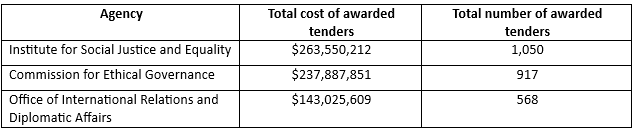

Bottom 3 Agencies: 
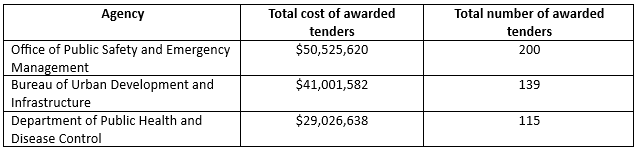


Observations: 
Most of the agencies have around 400 to 500 tenders awarded within past 5 years. Institute for Social Justice and Equality and Commission for Ethical Governance accounts for 29% of the total cost of the tender awarded. The 3 agencies in table 3 accounts for 8% of the total cost of the tender awarded. 

### Find which supplier had the most awards and total sum of awards

In [16]:
supplier_awarded = get_sum_and_count(df, ['Awarded Amount', 'Supplier'], ['Supplier'])
supplier_awarded = supplier_awarded.sort_values(by='awarded sum', ascending=False)
supplier_awarded.reset_index(drop=True, inplace=True)

In [17]:
supplier_awarded.head(3)

,Supplier,awarded sum,total number of awards
0,InfiniteSpace Building Solutions,62095175.0,238
1,InfiniteGuard Building Care,55530094.0,225
2,SecureSpace Management,42294144.0,177


Observations: We have extracted the top 3 suppliers that have been used across all agencies. We felt that these 3 companies used have an impact on risks of over-reliance, especially with SecureSpace Management.

### Find which agency engaged the supplier the most and sum of awards

In [18]:
agency_supplier_awarded = get_sum_and_count(df,['Awarded Amount', 'Supplier', 'Agency'], ['Supplier', 'Agency'])

agency_supplier_awarded_percentage = get_percentage_agency(agency_supplier_awarded, agency_awarded)
agency_supplier_awarded_percentage = get_percentage_supplier(agency_supplier_awarded, supplier_awarded)

# agency_supplier_awarded_percentage

In [19]:
agency_supplier_awarded_percentage.sort_values(by='awarded sum', ascending=False).head()

,Supplier,Agency,awarded sum,total number of awards,percentage awarded by amount_agency,percentage awarded by count_agency,percentage awarded by amount_supplier,percentage awarded by count_supplier
877,SecureSpace Management,National Commission for Space Exploration,42294144.0,177,0.307008,0.318919,1.000000,1.000000
698,InfiniteGuard Building Care,Commission for Ethical Governance,10304863.0,39,0.043318,0.042530,0.185573,0.173333
729,InfiniteSpace Building Solutions,Institute for Social Justice and Equality,10255656.0,40,0.038913,0.038095,0.165160,0.168067
724,InfiniteSpace Building Solutions,Commission for Ethical Governance,8184130.0,28,0.034403,0.030534,0.131800,0.117647
399,GoldenHarbor Management,Institute for Social Justice and Equality,7051993.0,30,0.026758,0.028571,0.230334,0.258621


Observations:  SecureSpace Management is used extensively in National Commission for Space Exploration, where it is 30% of the total tender amount awarded by the agency and for all service categories seen in the dataset. 


### Find which agency engaged the supplier the most, sum of awards and the reason

In [20]:
agency_supplier_reason = get_sum_and_count(df, 
                                           ['Awarded Amount', 'Supplier', 'Agency', 'Procurement Description'], 
                                           ['Supplier', 'Agency', 'Procurement Description'])

agency_supplier_reason_percentage = get_percentage_agency(agency_supplier_reason, agency_awarded)
agency_supplier_reason_percentage = get_percentage_supplier(agency_supplier_reason, supplier_awarded)
agency_supplier_reason_percentage = get_percentage_agency_supplier(agency_supplier_reason, agency_supplier_awarded)


In [21]:
# agency_supplier_reason_percentage.to_csv("agency_supplier_reason_percentage")

In [22]:
agency_supplier_reason_percentage.sort_values(by=['percentage awarded by amount_agency', 'percentage awarded by amount'],ascending=False)

,Supplier,Agency,Procurement Description,awarded sum,total number of awards,percentage awarded by amount_agency,percentage awarded by count_agency,percentage awarded by amount_supplier,percentage awarded by count_supplier,percentage awarded by amount,percentage awarded by count
429,BlueCrest Facility Support,Bureau of Urban Development and Infrastructure,Space planning and utilization optimization st...,3773118.0,1,0.092024,0.007194,0.136132,0.009524,0.897704,0.500000
1645,GoldenStar Property Care,Bureau of Urban Development and Infrastructure,Building maintenance and repairs.,2646865.0,1,0.064555,0.007194,0.170325,0.020833,0.909493,0.500000
4205,StarStone Facility Services,Bureau of Urban Development and Infrastructure,Parking management and traffic control solutions.,2370792.0,2,0.057822,0.014388,0.091207,0.021053,0.745739,0.400000
3960,SkyHigh Property Management,Department of Public Health and Disease Control,Energy-efficient lighting installation and mai...,1354614.0,3,0.046668,0.026087,0.054165,0.027027,0.733734,0.750000
2907,InfiniteSpace Building Solutions,Department of Advanced Technological Research,Cleaning supplies and consumables procurement ...,6024226.0,23,0.045677,0.042910,0.097016,0.096639,0.913868,0.920000
...,...,...,...,...,...,...,...,...,...,...,...
3057,Reliable Facility Services,Commission for Ethical Governance,Space planning and utilization optimization st...,12353.0,1,0.000052,0.001091,0.000477,0.009174,0.002716,0.055556
5019,TrustPro Building Maintenance,Institute for Social Justice and Equality,Indoor air quality monitoring and improvement ...,12816.0,1,0.000049,0.000952,0.001022,0.021277,0.008766,0.166667
929,EliteEdge Facilities Group,Commission for Ethical Governance,Building maintenance and repairs.,11714.0,1,0.000049,0.001091,0.000651,0.014085,0.003969,0.076923
4116,StarCrest Facility Services,Commission for Ethical Governance,Fire safety system installation and maintenance.,10857.0,1,0.000046,0.001091,0.000907,0.020000,0.009916,0.166667


### Find the reason of award and sum of awards by agency

In [23]:
agency_reason_awarded = get_sum_and_count(df, 
                                          ['Awarded Amount', 'Agency', 'Procurement Description'], 
                                          ['Agency', 'Procurement Description'])

agency_reason_awarded_percentage = get_percentage_agency(agency_reason_awarded, agency_awarded)
agency_reason_awarded_percentage = agency_reason_awarded_percentage.sort_values(by=['percentage awarded by amount_agency'], 
                                                                                ascending=False)
agency_reason_awarded_percentage

,Agency,Procurement Description,awarded sum,total number of awards,percentage awarded by amount_agency,percentage awarded by count_agency
126,Department of Public Health and Disease Control,Energy-efficient lighting installation and mai...,4064677.0,15,0.140033,0.130435
57,Bureau of Urban Development and Infrastructure,Space planning and utilization optimization st...,5686444.0,9,0.138688,0.064748
26,Bureau of National Security and Intelligence,Energy-efficient lighting installation and mai...,9441949.0,38,0.135645,0.137184
234,National Cybersecurity Task Force,Pest control services for a pest-free environm...,10477869.0,39,0.132904,0.119632
15,Agency for Cultural Preservation and Heritage,Pest control services for a pest-free environm...,15399564.0,63,0.122683,0.107509
...,...,...,...,...,...,...
37,Bureau of National Security and Intelligence,Space planning and utilization optimization st...,980042.0,9,0.014079,0.032491
150,Federal Agency for Environmental Protection,HVAC system maintenance and climate control op...,1205233.0,6,0.014013,0.018405
53,Bureau of Urban Development and Infrastructure,Indoor air quality monitoring and improvement ...,478940.0,3,0.011681,0.021583
47,Bureau of Urban Development and Infrastructure,Energy-efficient systems and consumption monit...,378495.0,5,0.009231,0.035971


In [24]:
reason_awarded = get_sum_and_count(df, 
                                      ['Supplier', 'Awarded Amount', 'Procurement Description'], 
                                      ['Procurement Description'])

reason_awarded.sort_values(by=['awarded sum'], 
                            ascending=False).reset_index(drop=True).to_csv('reason_awarded.csv')

In [25]:
supplier_reason_awarded = get_sum_and_count(df, 
                                          ['Awarded Amount', 'Supplier', 'Procurement Description'], 
                                          ['Supplier', 'Procurement Description'])

supplier_reason_awarded_percentage = get_percentage_supplier(supplier_reason_awarded, supplier_awarded)
supplier_reason_awarded_percentage = supplier_reason_awarded_percentage.sort_values(by=['percentage awarded by amount_supplier'], 
                                                                                ascending=False)
supplier_reason_awarded_percentage

,Supplier,Procurement Description,awarded sum,total number of awards,percentage awarded by amount_supplier,percentage awarded by count_supplier
940,InfiniteSpace Building Solutions,Cleaning supplies and consumables procurement ...,50149011.0,190,0.807615,0.798319
1468,SwiftTech Facility Solutions,Pest control services for a pest-free environm...,1277427.0,4,0.242479,0.235294
209,CleanHarbor Facility Care,Energy-efficient lighting installation and mai...,2395089.0,8,0.214422,0.190476
866,HorizonView Property Management,Comprehensive janitorial services and cleanlin...,2483768.0,8,0.210719,0.153846
1290,SkyQuest Facility Care,Energy-efficient lighting installation and mai...,2746726.0,9,0.210051,0.183673
...,...,...,...,...,...,...
954,InfiniteSpace Building Solutions,Space planning and utilization optimization st...,68331.0,1,0.001100,0.004202
176,BlueSail Property Experts,HVAC system maintenance and climate control op...,17085.0,1,0.000962,0.014493
650,GrandView Facilities Group,Cleaning supplies and consumables procurement ...,11797.0,1,0.000959,0.019608
1327,StarCrest Facility Services,Fire safety system installation and maintenance.,10857.0,1,0.000907,0.020000


In [26]:
# supplier_reason_awarded_percentage.to_csv("supplier_reason_awarded_percentage.csv")

Observations: We observed that InfiniteSpace Building Solutions is used extensively for cleaning supplies and consumables procurement and management. As it is used by most of the agencies, we believe that this company could cause an overreliance for the service provided to the whole government. 

### Find for unususal or suscipious activities

We choose to use median for comparison of procurement as median is a better statistical measure compared to mean. It is less affected by outliers in a given dataset, as well as providing a more accurate view to the middle value of all purchase. 

In [27]:
procurement_supplier = df.groupby(['Procurement Description', 'Supplier'])['Awarded Amount'].agg(['sum', 'count', 'median', 'mean', 'min', 'max']).reset_index()
procurement = df.groupby(['Procurement Description'])['Awarded Amount'].agg(['sum', 'count', 'median', 'mean', 'min', 'max']).reset_index()
procurement_agency = df.groupby(['Procurement Description', 'Agency'])['Awarded Amount'].agg(['sum', 'count', 'median', 'mean', 'min', 'max']).reset_index()
procurement_agency_supplier = df.groupby(['Procurement Description', 'Agency', 'Supplier'])['Awarded Amount'].agg(['sum', 'count', 'median', 'mean', 'min', 'max']).reset_index()

In [28]:
# procurement_supplier.to_csv("procurement_supplier.csv")
# procurement.to_csv("procurement.csv")
# procurement_agency.to_csv("procurement_agency.csv")
# procurement_agency_supplier.to_csv("procurement_agency_supplier.csv")

In [29]:
sus_desc_floor = []
sus_desc_ceiling = []
sus_supplier_floor = []
sus_supplier_ceiling = []

for row, col in df.iterrows(): 
    desc = col['Procurement Description']
    supplier = col['Supplier']
    amt = col['Awarded Amount']
    
    procurement_df = procurement[procurement['Procurement Description'] == desc]
    
    threshold = 1.5
    
    p_mean_ceiling = procurement_df['mean'].values[0] * (1 + threshold)
    p_mean_floor = procurement_df['mean'].values[0] * (1 - threshold)
    p_median_ceiling = procurement_df['median'].values[0] * (1 + threshold)
    p_median_floor = procurement_df['median'].values[0] * (1 - threshold)
    
    
    if (amt > p_mean_ceiling or amt > p_median_ceiling or amt < p_mean_floor or amt < p_median_floor ): 
        supplier_df = procurement_supplier[(procurement_supplier['Procurement Description'] == desc) &
                                          (procurement_supplier['Supplier'] == supplier)]
        
        s_mean_ceiling = supplier_df['mean'].values[0] * (1 + threshold)
        s_mean_floor = supplier_df['mean'].values[0] * (1 - threshold)
        s_median_ceiling = supplier_df['median'].values[0] * (1 + threshold)
        s_median_floor = supplier_df['median'].values[0] * (1 - threshold)
        
        if(amt > s_mean_ceiling or amt > s_median_ceiling): 
            sus_supplier_ceiling.append(row)
        elif (amt < s_mean_floor or amt < s_median_floor): 
            sus_supplier_floor.append(row)
        elif (amt > p_mean_ceiling or amt > p_mean_ceiling): 
            sus_desc_ceiling.append(row)
        elif (amt < p_mean_floor or amt < p_median_floor): 
            sus_desc_floor.append(row)

### Looks for suspicious activity without accounting supplier's pricing difference

In [30]:
temp = df.iloc[sus_desc_ceiling]
p_mean_li = []
p_median_li = []
s_mean_li = []
s_median_li = []

for row, col in temp.iterrows(): 
    supplier = col['Supplier']
    desc = col['Procurement Description']
    amt = col['Awarded Amount']
    
    p = procurement[procurement['Procurement Description'] == desc]
    s = procurement_supplier[(procurement_supplier['Procurement Description'] == desc) & 
                             (procurement_supplier['Supplier'] == supplier)]
    p_mean = p['mean'].values[0]
    p_median = p['median'].values[0]
    s_mean = s['mean'].values[0]
    s_median = s['median'].values[0]
    
    p_mean_li.append(amt / p_mean )
    p_median_li.append(amt / p_median)
    s_mean_li.append(amt / s_mean )
    s_median_li.append(amt / s_median)
    
temp['difference p_mean'] = p_mean_li
temp['difference p_median'] = p_median_li
temp['difference s_mean'] = s_mean_li
temp['difference s_median'] =s_median_li

C:\Users\lqlau\AppData\Local\Temp\ipykernel_9088\1036011137.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['difference p_mean'] = p_mean_li
C:\Users\lqlau\AppData\Local\Temp\ipykernel_9088\1036011137.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['difference p_median'] = p_median_li
C:\Users\lqlau\AppData\Local\Temp\ipykernel_9088\1036011137.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [31]:
temp.sort_values(by='difference p_median')

,S/N,Procurement Code,Procurement Type,Agency,Procurement Description,Date of Award,Supplier,Awarded Amount,difference p_mean,difference p_median,difference s_mean,difference s_median
4202,4203,ITT20190319,ITT,Bureau of National Security and Intelligence,HVAC system maintenance and climate control op...,2019-04-14,FreshTech Management,585882.0,2.500776,2.581183,1.477236,1.357038
1736,1737,ITT20170292,ITT,National Commission for Space Exploration,Energy-efficient systems and consumption monit...,2017-03-24,GreenWave Facilities Management,581896.0,2.517660,2.650270,1.829199,1.692793
6284,6285,ITT20210418,ITT,Office of International Relations and Diplomat...,Tenant communication and customer service assi...,2021-06-26,GreenEdge Facility Masters,596141.0,2.549794,2.676831,1.540922,1.362384
1751,1752,ITT20170307,ITT,Department of Energy Conservation and Sustaina...,Energy-efficient systems and consumption monit...,2017-03-29,SwiftReach Building Maintenance,590958.0,2.556868,2.691544,1.312040,1.312040
5577,5578,ITT20200606,ITT,Department of Energy Conservation and Sustaina...,HVAC system maintenance and climate control op...,2020-08-29,GrandTech Building Solutions,622027.0,2.655058,2.740424,1.977192,2.104183
1478,1479,ITT20170034,ITT,National Commission for Space Exploration,Parking management and traffic control solutions.,2017-01-19,AlphaWave Property Solutions,706593.0,2.729288,2.880902,1.667521,1.667521
6471,6472,ITT20210605,ITT,Bureau of Urban Development and Infrastructure,Health and safety compliance management and tr...,2021-09-19,GreenEdge Facility Masters,1415452.0,5.548733,5.784403,1.731666,1.731666


### Looks for suspicious activity accounting supplier's pricing difference

In [33]:
temp = df.iloc[sus_supplier_ceiling]
p_mean_li = []
p_median_li = []
s_mean_li = []
s_median_li = []

for row, col in temp.iterrows(): 
    supplier = col['Supplier']
    desc = col['Procurement Description']
    amt = col['Awarded Amount']
    
    p = procurement[procurement['Procurement Description'] == desc]
    s = procurement_supplier[(procurement_supplier['Procurement Description'] == desc) & 
                             (procurement_supplier['Supplier'] == supplier)]
    p_mean = p['mean'].values[0]
    p_median = p['median'].values[0]
    s_mean = s['mean'].values[0]
    s_median = s['median'].values[0]
    
    p_mean_li.append(amt / p_mean )
    p_median_li.append(amt / p_median)
    s_mean_li.append(amt / s_mean )
    s_median_li.append(amt / s_median)
    
temp['difference p_mean'] = p_mean_li
temp['difference p_median'] = p_median_li
temp['difference s_mean'] = s_mean_li
temp['difference s_median'] =s_median_li

C:\Users\lqlau\AppData\Local\Temp\ipykernel_9088\4021225444.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['difference p_mean'] = p_mean_li
C:\Users\lqlau\AppData\Local\Temp\ipykernel_9088\4021225444.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['difference p_median'] = p_median_li
C:\Users\lqlau\AppData\Local\Temp\ipykernel_9088\4021225444.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [34]:
temp.sort_values(by='difference s_median')

,S/N,Procurement Code,Procurement Type,Agency,Procurement Description,Date of Award,Supplier,Awarded Amount,difference p_mean,difference p_median,difference s_mean,difference s_median
1698,1699,ITT20170254,ITT,National Commission for Space Exploration,Pest control services for a pest-free environm...,2017-03-15,InfiniteTech Building Solutions,608802.0,2.415322,2.564819,2.277071,2.583918
6351,6352,ITT20210485,ITT,National Cybersecurity Task Force,Pest control services for a pest-free environm...,2021-07-28,SkyHigh Property Management,619440.0,2.457527,2.609635,2.680296,3.051632
5606,5607,ITT20200635,ITT,Office of Public Safety and Emergency Management,Tenant communication and customer service assi...,2020-09-09,GreenWave Facilities Management,561858.0,2.403160,2.522891,2.815720,3.283377
1873,1874,ITT20170429,ITT,Department of Energy Conservation and Sustaina...,Energy-efficient lighting installation and mai...,2017-05-02,AlphaWave Property Solutions,750849.0,2.998108,3.070938,2.427365,3.873970
3491,3492,ITT20180825,ITT,National Institute of Scientific Advancement,Indoor air quality monitoring and improvement ...,2018-08-27,InfiniteGuard Building Care,1284388.0,5.068321,5.226911,4.163028,4.391633
3469,3470,ITT20180803,ITT,Department of Advanced Technological Research,Pest control services for a pest-free environm...,2018-08-19,StarCrest Facility Services,602472.0,2.390209,2.538151,2.188030,4.573433
1832,1833,ITT20170388,ITT,Institute for Social Justice and Equality,Space planning and utilization optimization st...,2017-04-19,TrustGuard Facilities,592805.0,2.362124,2.515456,2.220551,4.576867
6618,6619,ITT20210752,ITT,Bureau of Urban Development and Infrastructure,Parking management and traffic control solutions.,2021-11-23,StarStone Facility Services,2337266.0,9.027931,9.529437,3.557563,6.425156
2197,2198,ITT20170753,ITT,Bureau of Urban Development and Infrastructure,Building maintenance and repairs.,2017-08-08,GoldenStar Property Care,2646865.0,10.126749,10.445629,3.277368,10.147096
5086,5087,ITT20200115,ITT,Bureau of Urban Development and Infrastructure,Space planning and utilization optimization st...,2020-02-14,BlueCrest Facility Support,3773118.0,15.034579,16.010515,4.721348,16.438703


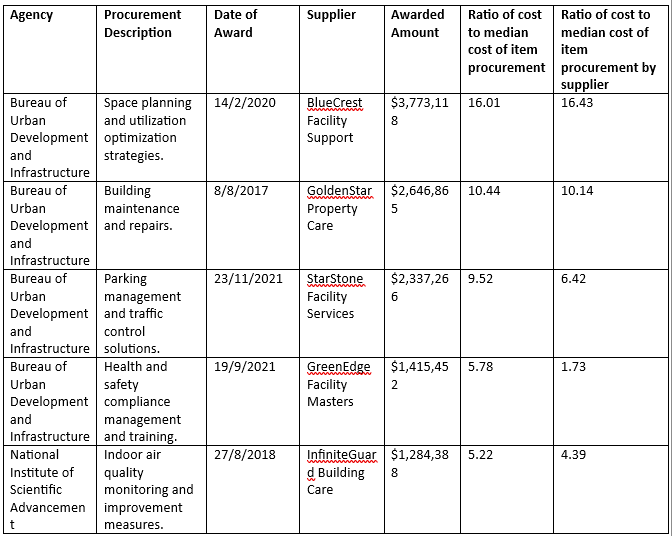

Observations: We have chosen to compare two values, namely median cost of item procurement and median cost of item procurement by supplier. The comparison against item procurement will allow us to understand how much more costly it is compared to other line items in the same category. Comparison against item procurement by supplier allows us to understand if this is seen commonly in the supplier’s pricing. 

In the table above, we have flagged out 5 items that we believed should be investigated further based on the spending. Interestingly, 4 of the 5 items were purchased by the Bureau of Urban Development and Infrastructure. 

The first two items have a high ratio when compared against the two measures mentioned, which should be further investigated. 

However, it should be noted that despite the high ratio, there could be other reasons for this observation. The project could be larger than the usual call for tenders or the project has higher execution complexity, hence the higher cost. 
